# Example notebook for Image Classification (with imagenet-mini)

### Setup 

#### Imports

First we have to import all necessary libraries.

In [1]:
# import necessary libraries
import os
import torch
from pytorch_lightning import LightningModule
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, ImageNet

from autoxai.explainer.base_explainer import CVExplainer
from autoxai.context_manager import AutoXaiExplainer, ExplainerWithParams, Explainers

from IPython.display import Markdown, display

Install missing libraries required by `YOLOv5` that are not part of `autoxai` package.

In [2]:
!pip install scipy opencv-python seaborn

Configure `CUDA_LAUNCH_BLOCKING=1` to prevent issues with `CUDA` while running GPU-accelerated computations in notebook.

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### Downloading missing models

Download `YOLOv5` and `ImageNet.yaml` files from https://github.com/ultralytics/yolov5 if not present in local storage.

In [4]:
# check if YOLOv5 model and ImageNet.yaml files are present at local storage and if they are not download them
![ ! -f "yolov5s-cls.pt" ] && wget https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5s-cls.pt
![ ! -f "ImageNet.yaml" ] && wget https://raw.githubusercontent.com/ultralytics/yolov5/master/data/ImageNet.yaml

#### Define custom functions

Define custom function to visualize figures

In [5]:
# instruct notebook to display figures inline
%matplotlib inline
import matplotlib.pyplot as plt

# function to enable displaying matplotlib Figures in notebooks
def show_figure(fig): 
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    new_manager.set_window_title("Test")
    fig.set_canvas(new_manager.canvas)
    return dummy

Define function that will load model, list of labels and transformation function of a desired model. Currently we support, in this notebook, only a few models: `VGG11`, `ResNet50`, `ViT`, `MobileNetV3` and `YOLOv5`. You can easilly add new models from `torchvision` model zoo and even define Your own model.

In [6]:
import yaml
from yaml.loader import SafeLoader
from torchvision.transforms._presets import ImageClassification
from typing import Tuple, List


def load_model(
    model_name: str,
) -> Tuple[torch.nn.Module, List[str], ImageClassification]:
    """Load model, label list and transformation function used in data preprocessing.

    Args:
        model_name: Model name. Recognized models are: `vgg11`, `resent50`, `yolov5`,
            `vit` and `mobilenetv3`.

    Raises:
        ValueError: raised if provided model name that is not supported.

    Returns:
        Tuple of model, list of labels and transformation function.
    """
    # normalize model name to match recognized models
    model_name_normalized: str = model_name.lower().strip()
    if model_name_normalized == "yolov5":
        # load YOLOv5 from torch Hub according to https://github.com/ultralytics/yolov5
        model = torch.hub.load('ultralytics/yolov5', 'custom', 'yolov5s-cls.pt')

        # apply transformations just like in MobileNetV3
        transform = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
        
        # load YOLOv5 configuration
        with open("ImageNet.yaml") as file:
            data = yaml.load(file, Loader=SafeLoader)

        # and get only class names
        categories = list(data["names"].values())
    elif model_name_normalized == "vgg11":
        weights = torchvision.models.VGG11_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.vgg11(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "vit":
        weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.vit_b_16(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "resnet50":
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.resnet50(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "mobilenetv3":
        weights = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.mobilenet_v3_small(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    else:
        raise ValueError(f"Unrecognized model name: {model_name}")

    return model, categories, transform

### Configuration

Cell below contains configuration of this notebook. We have defined max number of samples to be saved in artifact directory, path to `ImageNet-Mini` dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000), name of the model, batch_size and device to be used.

In [9]:
batch_size: int = 1
max_samples_explained: int = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_name: str = "resnet50"

# define directory where explanation artifacts will be stored
artifact_dir: str = f"artifacts/{model_name}/"

# `data_dir` variable contains path to dataset downloaded from https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000.
# You have to register in Kaggle to be able to download this dataset.
data_dir: str = "/home/user/Downloads/imagenet-mini"


### Loading the model

Load specified model, put it in evaluation mode, place it on specified device, download and preprocess `ImageNet-Mini` dataset.

In [10]:
# load model, classes and transformation function
model, categories, transform = load_model(model_name=model_name)

# put model in evaluation mode
model.eval()

# place model on specified device (CPU or GPU)
model.to(device)

# load test dataset - ImageNet-Mini downloaded from Kaggle: https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000
imagenet_val = torchvision.datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
val_dataloader = DataLoader(imagenet_val, batch_size=batch_size)

## Demo for general algorithms 

### Choosing autoxai explainers (general algorithms)

Define list of explainers from `autoxai` package You want to use on specified model. Full list of supported explainers can be found at definition of `Explainers` enum class.

In [11]:
# define list of explainers we want to use
# full list of supported explainers is present in `Explainers` enum class.
explainer_list = [
    ExplainerWithParams(explainer_name=Explainers.CV_GRADIENT_SHAP_EXPLAINER),
    ExplainerWithParams(explainer_name=Explainers.CV_INPUT_X_GRADIENT_EXPLAINER),
    ExplainerWithParams(explainer_name=Explainers.CV_INTEGRATED_GRADIENTS_EXPLAINER),
    ExplainerWithParams(explainer_name=Explainers.CV_OCCLUSION_EXPLAINER),
]

### Explaining the predictions (general algorithms)

Iterate over dataset and explain predictions given by selected model using all specified explainers. It could take a long time, depending on number of selected explainers and number of samples to explain. During this process new artifacts will be saved in artifact directory.

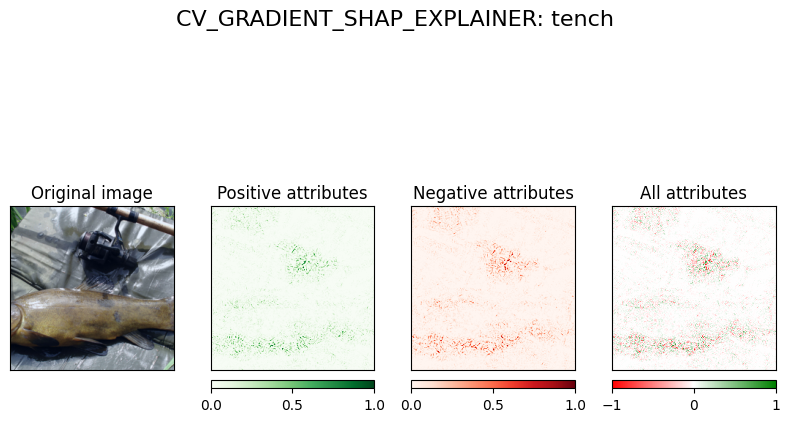

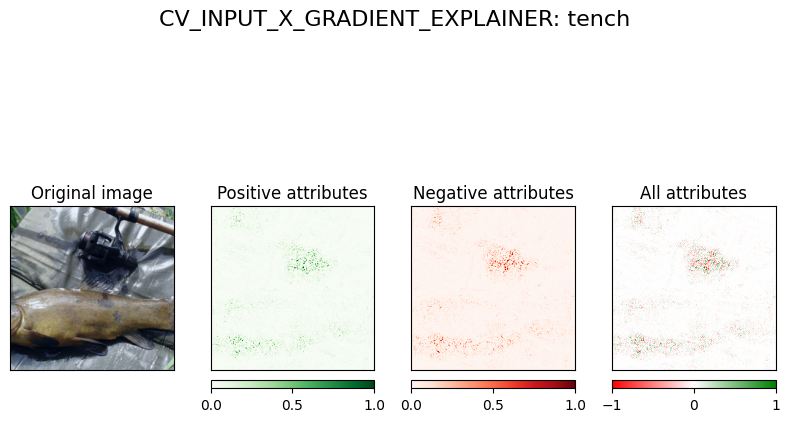

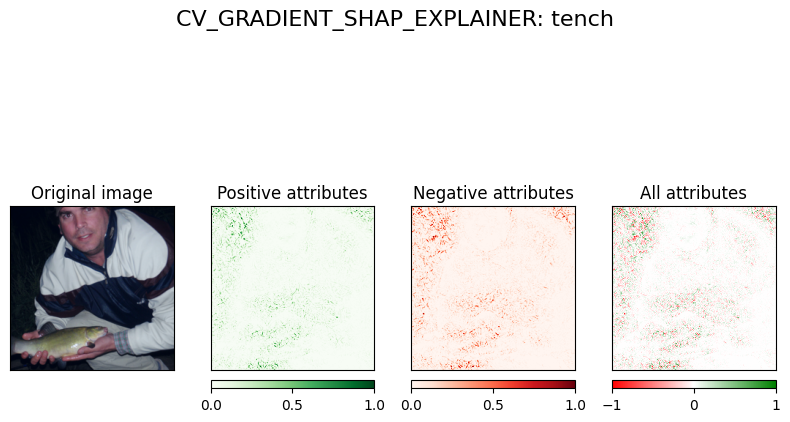

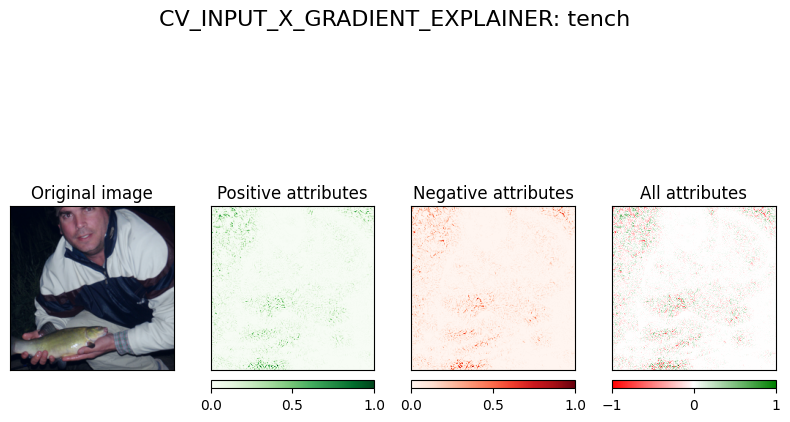

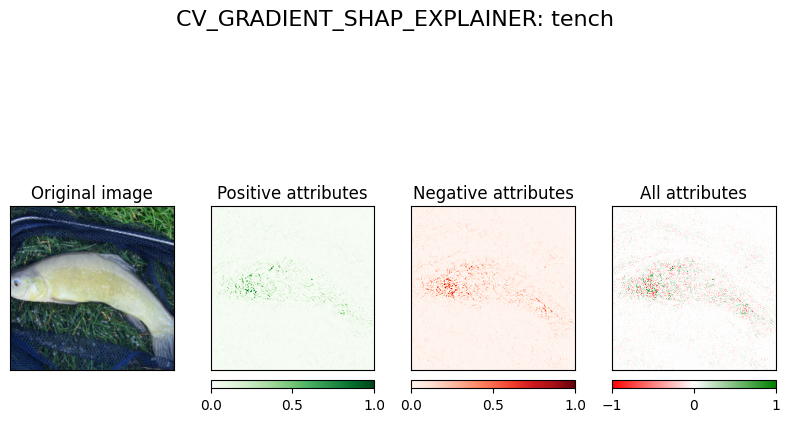

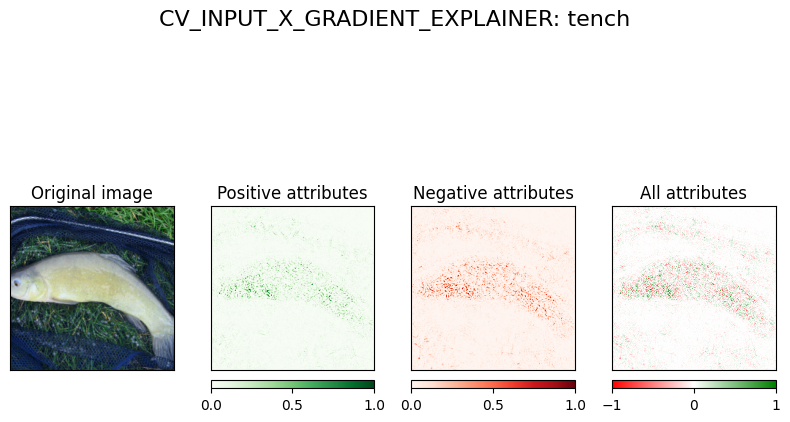

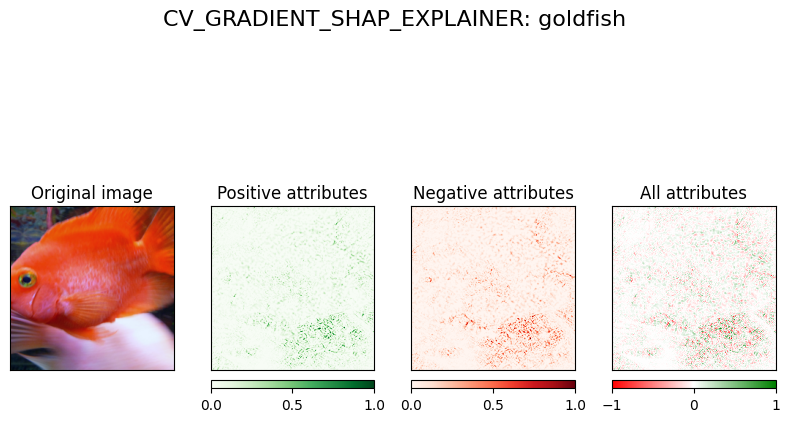

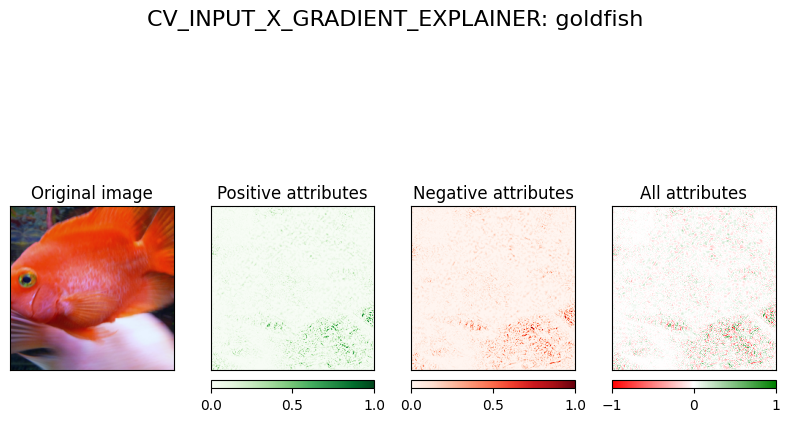

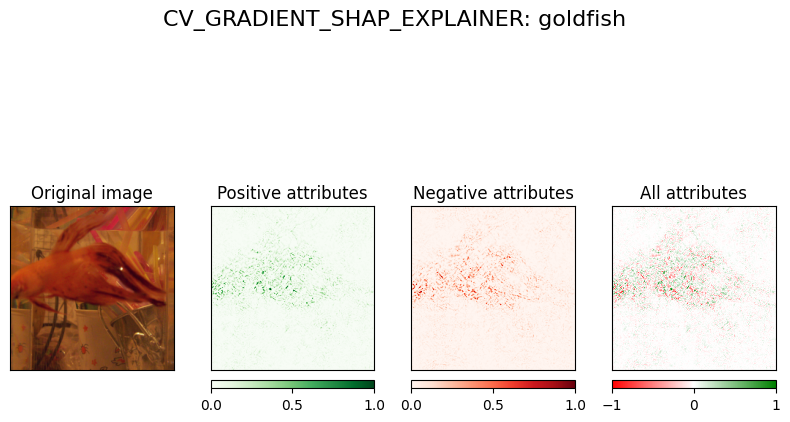

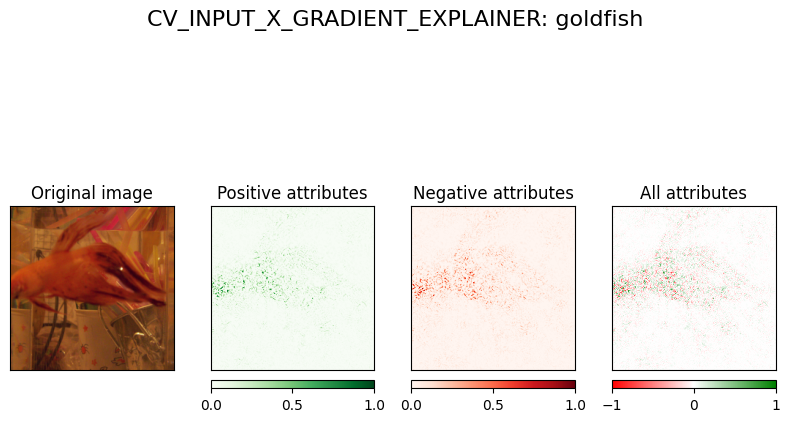

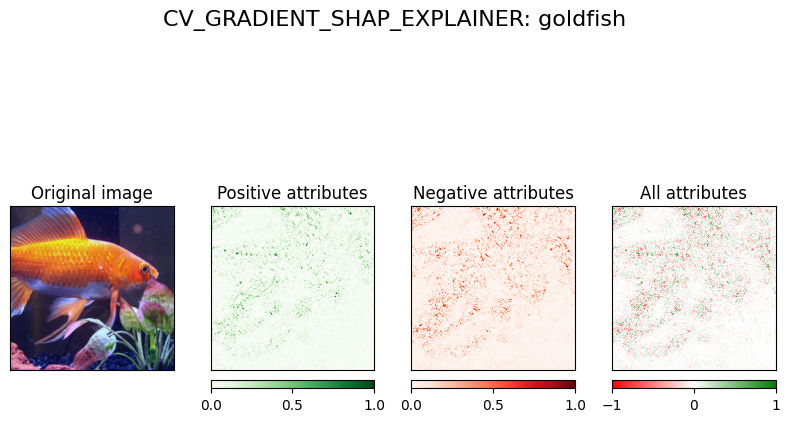

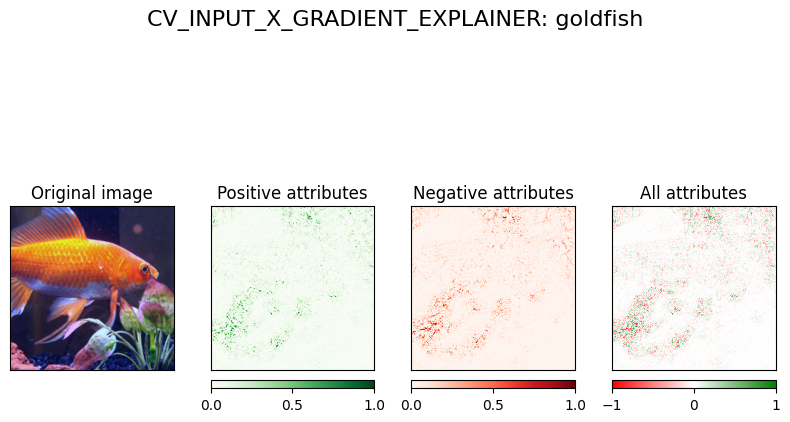

In [12]:
sample: torch.Tensor
label: int

sample_counter: int = 0
    
# iterate over dataloader
for sample_batch in val_dataloader:
    sample_list, label_list = sample_batch
    # iterate over all samples in batch
    for sample, label in zip(sample_list, label_list):
        # add batch size dimension to the data sample
        input_data = sample.reshape(1, sample.shape[0], sample.shape[1], sample.shape[2]).to(device)
        category_name = categories[label.item()]
        # move it to specified device
        input_data = input_data.to(device)
        with AutoXaiExplainer(
            model=model,
            explainers=explainer_list,
            target=label,
        ) as xai_model:
            # calculate attributes for every explainer
            _, attributes_dict = xai_model(input_data)

        for key, value in attributes_dict.items():
            # create directory for every explainer artifacts
            artifact_explainer_dir = os.path.join(artifact_dir, key)
            if not os.path.exists(artifact_explainer_dir):
                os.makedirs(artifact_explainer_dir)

            # create figure from attributes and original image
            figure = CVExplainer.visualize(attributions=value, transformed_img=sample)
            title = f"{key}: {category_name}"
            figure.suptitle(title, fontsize=16)

            # save figure to artifact directory
            figure.savefig(os.path.join(artifact_explainer_dir, f"artifact_{sample_counter}_{category_name}.png"))
            show_figure(figure)
            
        sample_counter += 1
        # if we processed desired number of samples break the loop
        if sample_counter > max_samples_explained:
            break

    # if we processed desired number of samples break the loop
    if sample_counter > max_samples_explained:
        break

## Demo for layer specific algorithms

There are algorithms that are computing explanations on the level of single layer. You have to select one layer to explain against it. Many algorithms are using `Conv2d` layers to explain. In the cell below we are fetching last convolutional layer from network to explain.

In [13]:
layer = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)][-1]

Pass additional parameters to selected explainers. Our context manager accepts objects of `ExplainerWithParams` class which store additional parameters to explainers. In the cell below we are creating two explainers with additional `layer` arguments. 

### Choosing autoxai explainers (layer-specific algorithms)

In [14]:
# define list of explainers we want to use
# full list of supported explainers is present in `Explainers` enum class.
explainer_list = [
    ExplainerWithParams(explainer_name=Explainers.CV_GUIDEDGRADCAM_EXPLAINER, layer=layer),
    ExplainerWithParams(explainer_name=Explainers.CV_LAYER_GRADCAM_EXPLAINER, layer=layer),
]

### Explaining the predictions (layer-specific algorithms)

Explanation code looks the same. We don't have to change anything here.

/home/ubuntu/.pyenv/versions/3.8.16/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
2023-01-12 08:13:29,477 INFO autoxai.explainer.base_explainer - No negative attributes in the explained model.
2023-01-12 08:13:30,176 INFO autoxai.explainer.base_explainer - No negative attributes in the explained model.


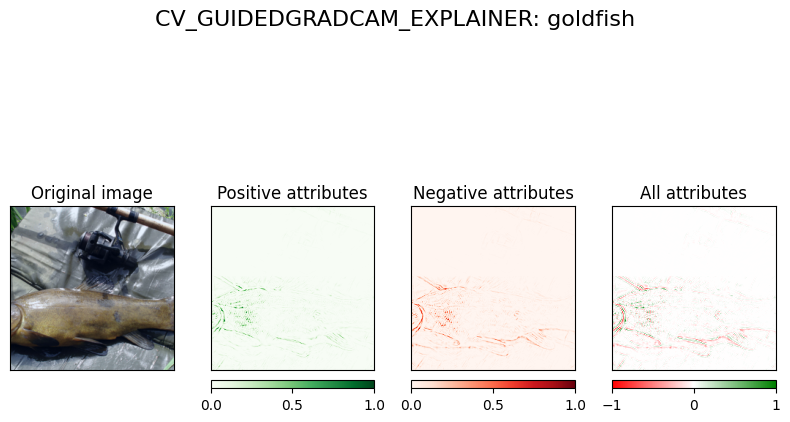

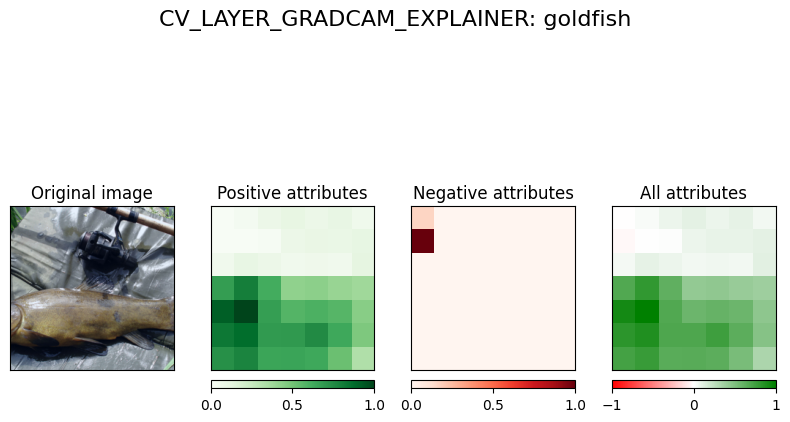

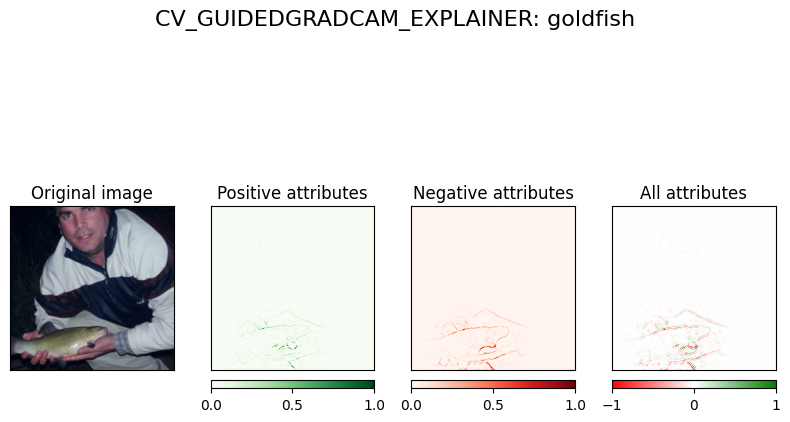

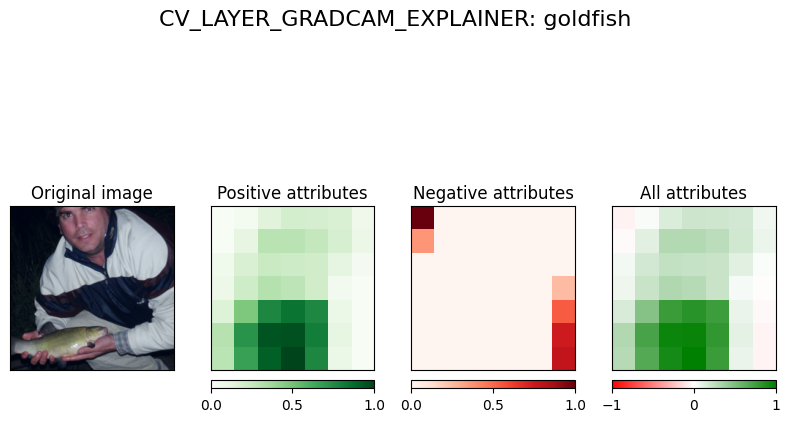

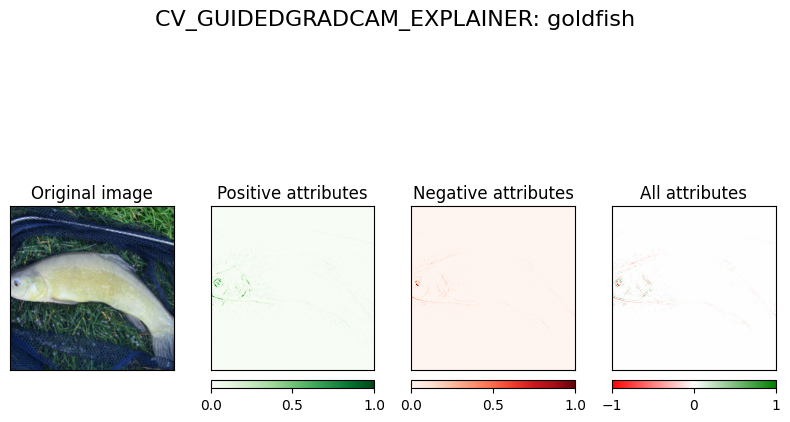

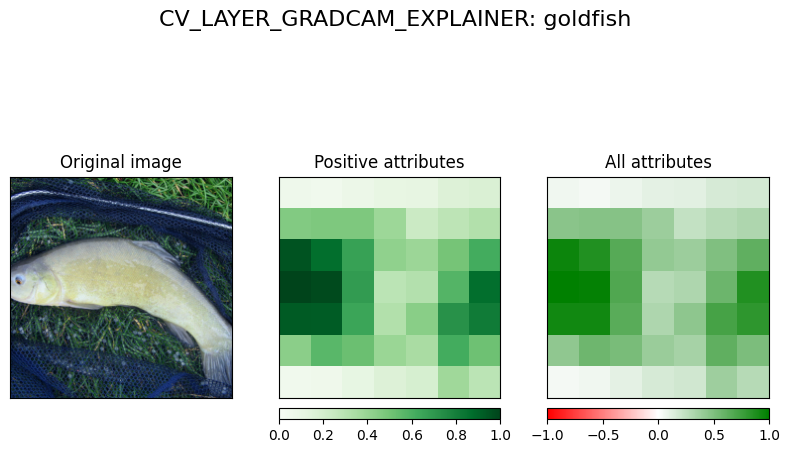

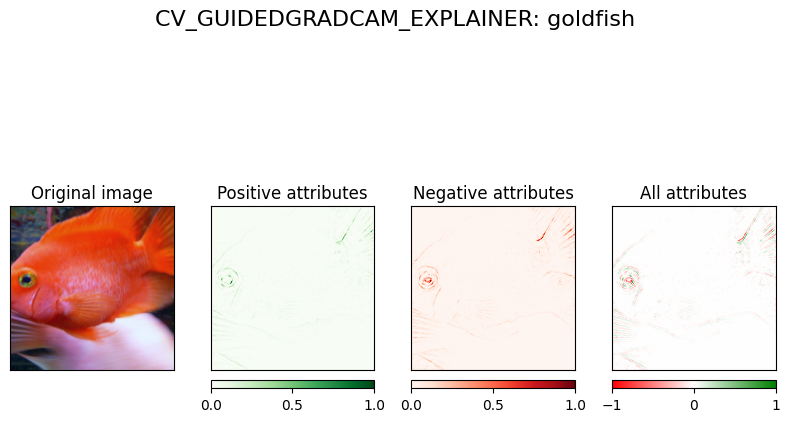

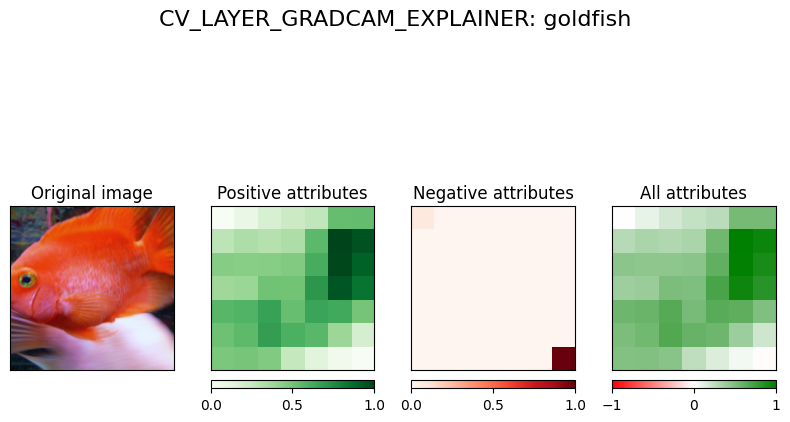

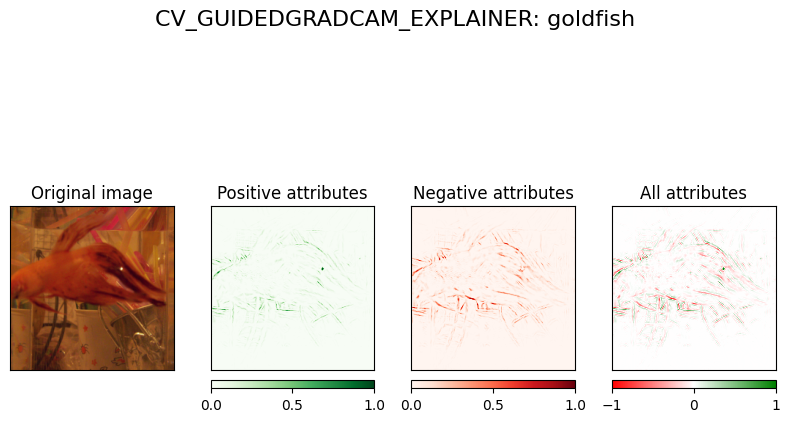

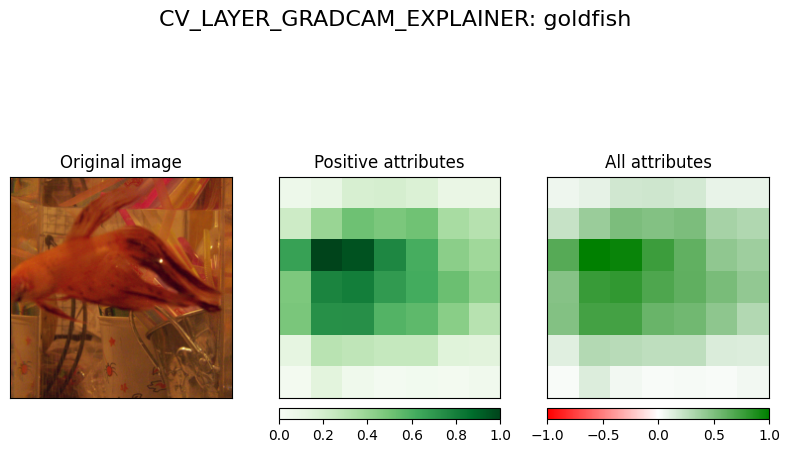

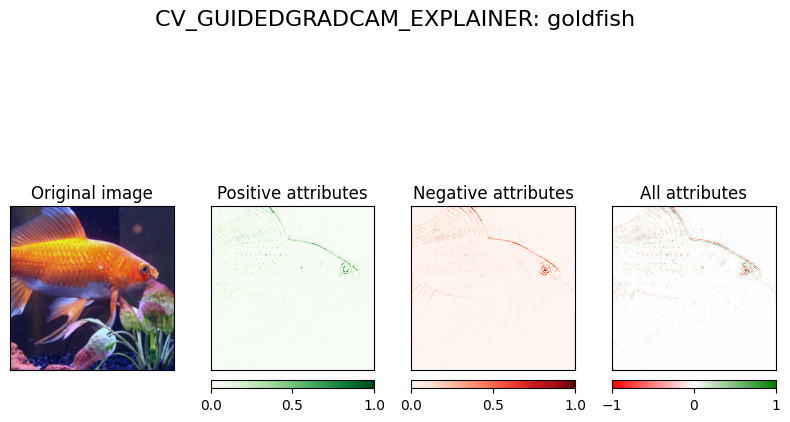

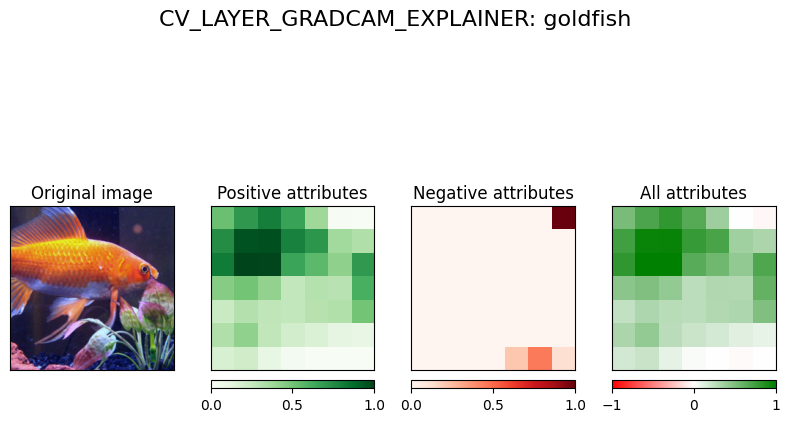

In [15]:
sample_counter = 0

# iterate over dataloader
for sample_batch in val_dataloader:
    sample_list, label_list = sample_batch
    # iterate over all samples in batch
    for sample, label in zip(sample_list, label_list):
        # add batch size dimension to the data sample
        input_data = sample.reshape(1, sample.shape[0], sample.shape[1], sample.shape[2]).to(device)
        
        # move it to specified device
        input_data = input_data.to(device)
        with AutoXaiExplainer(
            model=model,
            explainers=explainer_list,
            target=label,
        ) as xai_model:
            # calculate attributes for every explainer
            _, attributes_dict = xai_model(input_data)

        for key, value in attributes_dict.items():
            # create directory for every explainer artifacts
            artifact_explainer_dir = os.path.join(artifact_dir, key)
            if not os.path.exists(artifact_explainer_dir):
                os.makedirs(artifact_explainer_dir)

            # create figure from attributes and original image
            figure = CVExplainer.visualize(attributions=value, transformed_img=sample)

            # save figure to artifact directory
            figure.savefig(os.path.join(artifact_explainer_dir, f"artifact_{sample_counter}_{categories[label.item()]}.png"))
            title = f"{key}: {category_name}"
            figure.suptitle(title, fontsize=16)

            show_figure(figure)
            
        sample_counter += 1
        # if we processed desired number of samples break the loop
        if sample_counter > max_samples_explained:
            break

    # if we processed desired number of samples break the loop
    if sample_counter > max_samples_explained:
        break